Below, we consider the standard binary classification problem.

## Misclassification cost-based ROC AUC

Assume we pay a cost $c_{FN} >0 $ in case we classify a point of the positive class as a negative, and, similarly, pay a cost $c_{FP} > 0$ in case of a false positive. 

With no loss of generality, we assume these costs are normalized and sum to one:

$$\boxed{c_{FN} + c_{FP} = 1.}$$

(if they are not, we can normalize via $c_{FN} \to c_{FN}/(c_{FN} + c_{FP})$ and similarly for $c_{FP}$).

For a given classification threshold $\lambda \in ]0,1[$, what is the total misclassification cost? Assume we have $n$ total points, out of which $P$ real positives and $N$ real negatives, where

$$P = \pi n, \quad N = (1-\pi) n,\quad \pi \in [0,1] \;\;\mbox{(imbalance ratio).}$$

Then the total false positives and false negatives is, written in terms of the coordinates $(\mathrm{FPR}(\lambda), \mathrm{TPR}(\lambda))$ of the ROC curve,

$$
\begin{align*}
\mathrm{FP}(\lambda) &= N \; \mathrm{FPR}(\lambda)\\
\mathrm{FN}(\lambda) &= P - \mathrm{TP}(\lambda) = P(1 - \mathrm{TPR}(\lambda));
\end{align*}$$

multiplying these by the specific costs we get

$$\begin{align*}
C(\lambda) &= c_{FP} \mathrm{FP}(\lambda) + c_{FN} \mathrm{FN}(\lambda)\\
           &= c_{FP} N\, \mathrm{FPR} (\lambda) + c_{FN} P (1 - \mathrm{TPR}(\lambda))\\
           &= n c_{FP} (1-\pi) \mathrm{FPR} (\lambda) + n c_{FN} \pi (1 - \mathrm{TPR}(\lambda)) \\
c(\lambda) \equiv \frac{C(\lambda)}{n}           &= (1- c_{FN}) (1-\pi) \mathrm{FPR} (\lambda) + c_{FN} \pi (1 - \mathrm{TPR}(\lambda)) \quad (*)
\end{align*}$$

Equation $(*)$ is the general cost at any given $\lambda$. 

Now, what is our baseline of comparison? That would be the *random model* where we set

$$\mathbb P(\hat y = 1) = \pi,\quad \mathbb P(\hat y = 0) = 1 - \pi$$

It is easy to see that this model leads to $\mathrm{FPR} = \mathrm{TPR} = \pi$ regardless of the threshold, hence a cost of

$$\begin{align*}
c_\mathrm{random} &= (1-c_{FN}) (1-\pi) \pi + c_{FN} \pi (1-\pi)\\
&= \pi(1-\pi)
\end{align*}$$

Thus, a good model needs to give a cost *lower* than random guessing, ie. $c(\lambda) \leq \pi(1-\pi)$, ie. 

$$(1- c_{FN}) (1-\pi) \mathrm{FPR} (\lambda) + c_{FN} \pi (1 - \mathrm{TPR}(\lambda)) \leq \pi(1-\pi)$$

or

$$\mathrm{TPR} \geq 1 - \frac{1-\pi}{c_{FN}} + \frac{1-c_{FN}}{c_{FN}} \frac{1-\pi}{\pi} \mathrm{FPR}$$

We then arrive at the following criterion:

### Cost based partial AUC
* Let $\pi = \widehat{\mathbb P}(Y=1)$ denote the prevalence of the positive class
* Let $\rho \in [0,1]$ denote the cost of a false negative

Then, the region in the $(x,y)$ ROC plane bounded below by

$$\boxed{y = 1 - \frac{1-\pi}{\rho} + \frac{1-\rho}{\rho} \frac{1-\pi}{\pi} x}$$

defines the useful lower bound on the ROC curve.

### Example and implementation

In [49]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

#### (a) Balanced case

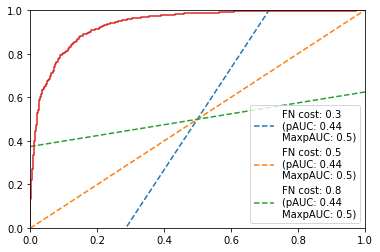

In [106]:
X, y = make_classification(n_classes=2,
                           n_samples=3000,
                           random_state=2, 
                           n_features=10,
                           n_informative=10,
                           weights=(0.5,),
                           n_redundant=0,
                           n_repeated=0)

model = LogisticRegression()
model.fit(X, y)

y_probs = model.predict_proba(X)[:,1]

fpr, tpr, thresh = roc_curve(y, y_probs)

pi = y.mean()

for cost_fn in [0.3, 0.5, 0.8]:
    cost_fp = 1 - cost_fn
    rho = cost_fn
    
    tpr_base = 1 - (1-pi)/rho + (1-rho)/rho * (1-pi)/pi * fpr
    pauc = auc(fpr, np.maximum(tpr-np.maximum(0,tpr_base),0))

    # maximum value
    aux = np.clip(tpr_base,0,1)
    max_pauc = 1 - auc(fpr, aux)
    
    
    plt.plot(fpr, tpr_base, 
             label=f'FN cost: {cost_fn}\n(pAUC: {round(pauc,2)}\nMaxpAUC: {round(max_pauc,2)})', 
             linestyle='--')
    
    
plt.plot(fpr, tpr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

#### (b) Imbalanced case

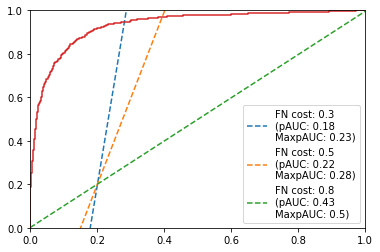

In [110]:
X, y = make_classification(n_classes=2,
                           n_samples=3000,
                           random_state=2, 
                           n_features=10,
                           n_informative=10,
                           weights=(0.8,),
                           n_redundant=0,
                           n_repeated=0)

model = LogisticRegression()
model.fit(X, y)

y_probs = model.predict_proba(X)[:,1]

fpr, tpr, thresh = roc_curve(y, y_probs)

pi = y.mean()

for cost_fn in [0.3, 0.5, 0.8]:
    cost_fp = 1 - cost_fn
    rho = cost_fn
    
    tpr_base = 1 - (1-pi)/rho + (1-rho)/rho * (1-pi)/pi * fpr
    pauc = auc(fpr, np.maximum(tpr-np.maximum(0,tpr_base),0))

    # maximum value
    aux = np.clip(tpr_base,0,1)
    max_pauc = 1 - auc(fpr, aux)
    
    
    plt.plot(fpr, tpr_base, 
             label=f'FN cost: {cost_fn}\n(pAUC: {round(pauc,2)}\nMaxpAUC: {round(max_pauc,2)})', 
             linestyle='--')
    
    
plt.plot(fpr, tpr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

Notice how adding imbalance changes the game significantly.

## Functional implementation

In [115]:
def cost_based_roc_auc(y_true, y_probs, 
                       cost_fn=None,
                       cost_fp=None,
                       return_curves=False):
    from sklearn.metrics import roc_curve, auc
    
    fpr, tpr, thresh = roc_curve(y_true, y_probs)

    is_fn_none = cost_fn is None
    is_fp_none = cost_fp is None
    
    assert not all([is_fn_none, is_fp_none]), "At least one out of cost_fn and cost_fp needs to be not None"
    
    if is_fn_none:
        assert 0 <= cost_fp <= 1
        cost_fn = 1 - cost_fp
    else:
        assert 0 <= cost_fn <= 1
    
    pi = y_true.mean()

    rho = cost_fn

    tpr_base = 1 - (1-pi)/rho + (1-rho)/rho * (1-pi)/pi * fpr
    pauc = auc(fpr, np.maximum(tpr-np.maximum(0,tpr_base),0))

    # maximum value
    max_pauc = auc(fpr, 1 - np.clip(tpr_base,0,1))

    if not return_curves:
        return pauc, max_pauc
    else:
        return pauc, max_pauc, fpr, tpr, tpr_base

In [116]:
for cost_fn in [0.1, 0.3, 0.5, 0.8, 0.9]:
    pauc, pauc_max = cost_based_roc_auc(y, y_probs, cost_fn=cost_fn)
    print(f"Cost FN {cost_fn}: {round(pauc/pauc_max,2)} %")

Cost FN 0.1: 0.75 %
Cost FN 0.3: 0.76 %
Cost FN 0.5: 0.78 %
Cost FN 0.8: 0.86 %
Cost FN 0.9: 0.9 %
